# Investigating Predictive Factors and Correlations of Coronary Artery Disease

#### Daniel (Tae Jun) Lee | DSCI 100 - 002

#### **Introduction:**
Coronary artery disease (CAD) is the most common form of heart disease in the USA and Canada. CAD occurs when plaque builds up on the walls of the coronary arteries, restricting blood flow to the heart (CDC, 2024). The most common symptom of CAD is chest pain (angina), which occurs when the heart muscle doesn't get enough oxygen-rich blood. Other symptoms may include shortness of breath, fatigue, and in severe cases, heart attacks (CDC, 2024). To diagnose CAD, patients are given several tests, such as electrocardiogram, echocardiogram, exercise stress test, chest X-ray, cardiac catheterization, coronary angiogram, and coronary artery calcium scan (CDC, 2024). A full blockage in the arteries could lead to a heart attack, and ultimately death (Coronary artery disease, 2022). This project will examine several factors and their correlation to coronary artery disease (CAD), ultimately determining if they can be used to predict CAD diagnosis.

#### **Question:**
Given an individual's age, resting blood pressure, and maximum heart rate, is it possible to predict whether they have coronary artery disease?

#### **Data Set:**
This project utilizes a dataset derived from test results collected and published by Detrano et al. in 1989. The dataset comprises information from 303 patients who underwent angiography procedures at the Cleveland Clinic.

In [56]:
#loading necessary libraries
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)

#### **What each column represents:**
* **age:** age in years
* **sex:** male (1) or female (0)
* **cp:** *chest pain type* | Value 1: typical angina; Value 2 : atypical angina; Value 3: non-anginal pain; Value 4: asymptomatic
* **trestbps:** *resting blood pressure* (in mm Hg on admission to the hospital)
* **chol:** serum cholestrol in mg/dl
* **fbs:** *fasting blood sugar* > 120 mg/dl (1 = true; - = false)
* **restecg:** *resting electrocardiographic results* | Value 0: normal; Value 1: having St-T wave abnormality; Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
* **thalach:** maximum heart rate achieved
* **exang:** exercise induced angina (1 = yes; 0 = no)
* **oldpeak:** ST depression induced by exercise relative to rest
* **slope:** the slope of the peak exercise ST segment | Value 1: upsloping; Value 2: flat; Value 3: downsloping
* **ca:** number of major vessels (0-3) colored by fluoroscopy
* **thal:** 3 = normal; 6 = fixed defect; 7 = reversable defect
* **num:** diagnosis of heart disease (angiographic disease status) | Value 0: <50% diameter narrowing; Value 1: >50% diameter narrowing
* **diagnosis:** no = patient has no heart disease; yes = patient has some degree of heart disease

#### **Preliminary exploratory data analysis:**


In [36]:
#Setting seed value to make analysis reproducable
set.seed(111)

#Data Loading and Renaming Columns
heart_data_url <- "https://raw.githubusercontent.com/dtjl012/dsci100project/main/data/heart_disease/processed.cleveland.data"
heart_data <- read_csv(heart_data_url, col_names = FALSE)
column_names <- c("age", 
                  "sex", 
                  "cp", 
                  "trestbps", 
                  "chol", 
                  "fbs", 
                  "restecg", 
                  "thalach", 
                  "exang", 
                  "oldpeak", 
                  "slope", 
                  "ca", 
                  "thal", 
                  "num")
colnames(heart_data) <- column_names

# Replacing "?" values with "NA"
NA_heart_data <- heart_data |>
    mutate_all(~(ifelse(. == "?", NA, .)))

# Data type conversion
converted_heart_data <- NA_heart_data |>
    mutate(sex = as.factor(sex), 
           cp = as.factor(cp), 
           fbs = as.factor(fbs), 
           restecg = as.factor(restecg), 
           exang = as.factor(exang), 
           thal = as.factor(thal), 
           ca = as.factor(ca), 
           slope = as.factor(slope)) |>
    mutate(sex = fct_recode(sex, "Male" = "1", "Female" = "0")) |>
    mutate(cp= fct_recode(cp, "Typical Angina" = "1", "Atypical Angina" = "2", "Non-Anginal Pain" = "3", "Asymptomatic" = "4"))

# Creating a new column called diagnosis. If the corresponding value in the "num" column is NA, the diagnosis column will be NA; 
# if the value in the "num" column is greater than 0, the diagnosis column will be "Yes"; otherwise, it will be "No", thus 
#classifying into two categories.

clean_heart_data <- converted_heart_data |>
    mutate(diagnosis = ifelse(is.na(num), NA, ifelse(num > 0, "Yes", "No"))) |>
    mutate(diagnosis = as.factor(diagnosis)) |>
    select(-num)
head(clean_heart_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,Male,Typical Angina,145,233,1,2,150,0,2.3,3,0.0,6.0,No
67,Male,Asymptomatic,160,286,0,2,108,1,1.5,2,3.0,3.0,Yes
67,Male,Asymptomatic,120,229,0,2,129,1,2.6,2,2.0,7.0,Yes
37,Male,Non-Anginal Pain,130,250,0,0,187,0,3.5,3,0.0,3.0,No
41,Female,Atypical Angina,130,204,0,2,172,0,1.4,1,0.0,3.0,No
56,Male,Atypical Angina,120,236,0,0,178,0,0.8,1,0.0,3.0,No


In [54]:
set.seed(111)

#splitting into training and testing data sets
heart_data_split <- initial_split(clean_heart_data, prop = 0.75, strata = diagnosis)
heart_data_training <- training(heart_data_split)
heart_data_testing <- testing(heart_data_split)
head(heart_data_training)

# Aggregating heart data training set by diagnosis, calculating mean, min, max of thalach, trestbps, and age, along with patient count
summ_heart_data <- heart_data_training |> 
    group_by(diagnosis) |>
    summarize(mean_thalach = mean(thalach), min_thalach = min(thalach), max_thalach = max(thalach),
              mean_trestbps = mean(trestbps), min_trestbps = min(trestbps), max_trestbps = max(trestbps),
              mean_age = mean(age), min_age = min(age), max_age = max(age),
              n_of_patients = n())
summ_heart_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,Male,Typical Angina,145,233,1,2,150,0,2.3,3,0.0,6.0,No
37,Male,Non-Anginal Pain,130,250,0,0,187,0,3.5,3,0.0,3.0,No
41,Female,Atypical Angina,130,204,0,2,172,0,1.4,1,0.0,3.0,No
56,Male,Atypical Angina,120,236,0,0,178,0,0.8,1,0.0,3.0,No
57,Female,Asymptomatic,120,354,0,0,163,1,0.6,1,0.0,3.0,No
57,Male,Asymptomatic,140,192,0,0,148,0,0.4,2,0.0,6.0,No


diagnosis,mean_thalach,min_thalach,max_thalach,mean_trestbps,min_trestbps,max_trestbps,mean_age,min_age,max_age,n_of_patients
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
No,158.5691,96,202,129.0407,94,180,52.11382,29,76,123
Yes,138.0000,71,195,136.0769,100,192,57.21154,35,77,104


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


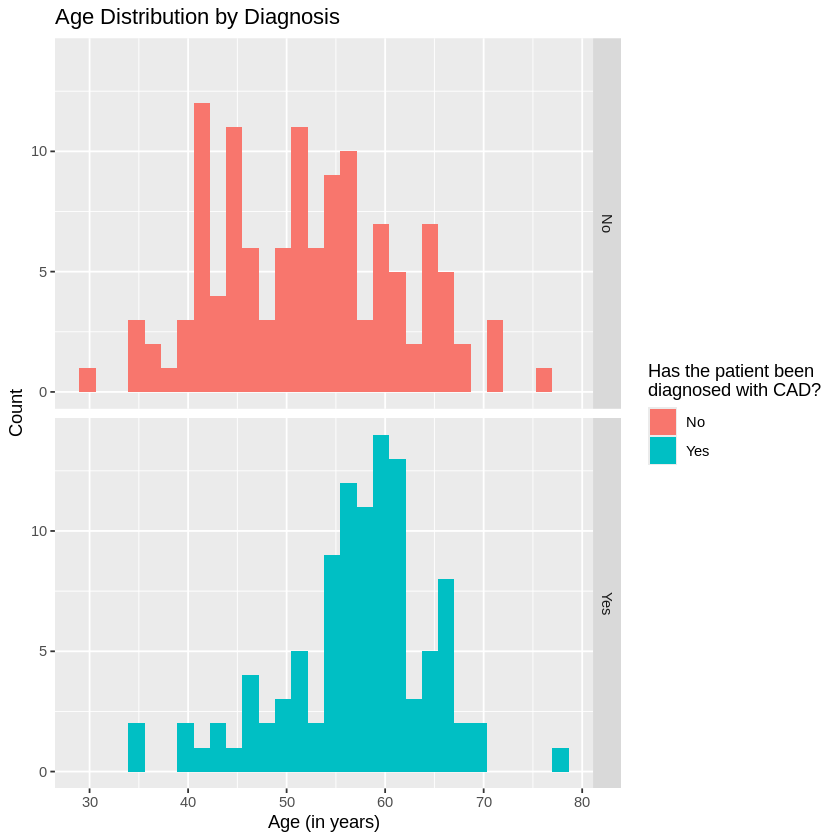

In [55]:
set.seed(111)

# Generating a histogram depicting the distribution of patient ages, categorized by diagnosis status
age_hist_plot <- heart_data_training |>
    ggplot(aes(x = age, fill = diagnosis)) +
    geom_histogram(position = "identity") +
    ggtitle("Age Distribution by Diagnosis") +
    labs(x = "Age (in years)", y = "Count", fill = "Has the patient been \ndiagnosed with CAD?") +
    facet_grid(rows = vars(diagnosis))
age_hist_plot

From the "Age Distribution by Diagnosis" plot, we observe that the age of individuals with CAD is often older than those who do not have CAD.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


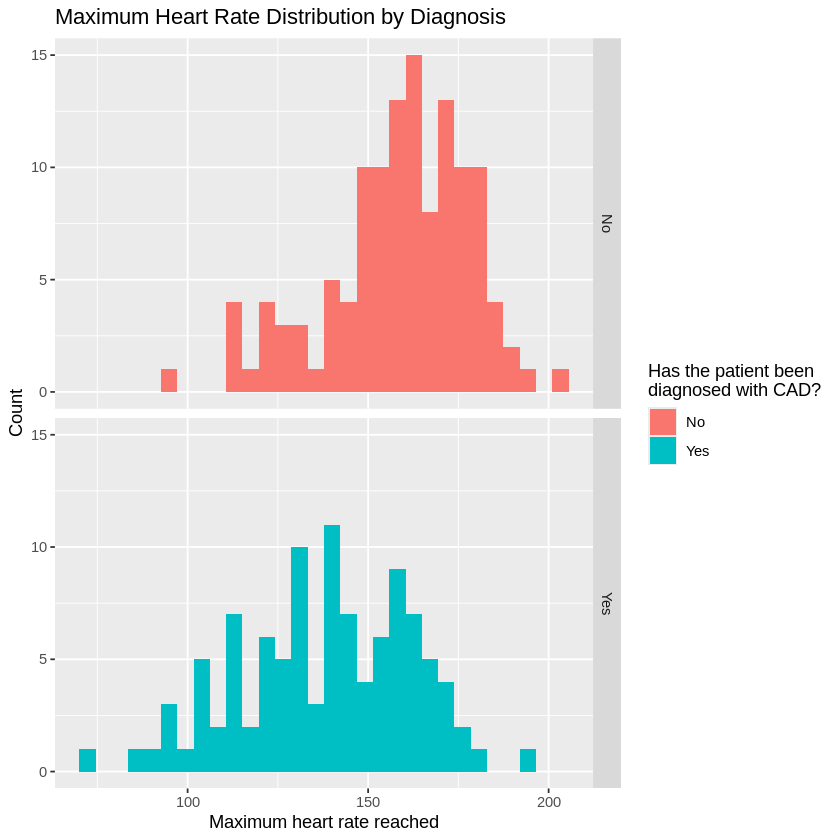

In [51]:
set.seed(111)

# Generating a histogram illustrating the distribution of maximum heart rates achieved by patients, categorized by diagnosis
hb_hist_plot <- heart_data_training |>
    ggplot(aes(x = thalach, fill = diagnosis)) +
    geom_histogram(position = "identity") +
    ggtitle("Maximum Heart Rate Distribution by Diagnosis") +
    labs(x = "Maximum heart rate reached", y = "Count", fill = "Has the patient been \ndiagnosed with CAD?") +
    facet_grid(rows = vars(diagnosis))
hb_hist_plot

From the plot above, we observe that individuals without CAD exhibit notably higher maximum heart rates compared to those diagnosed with CAD.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


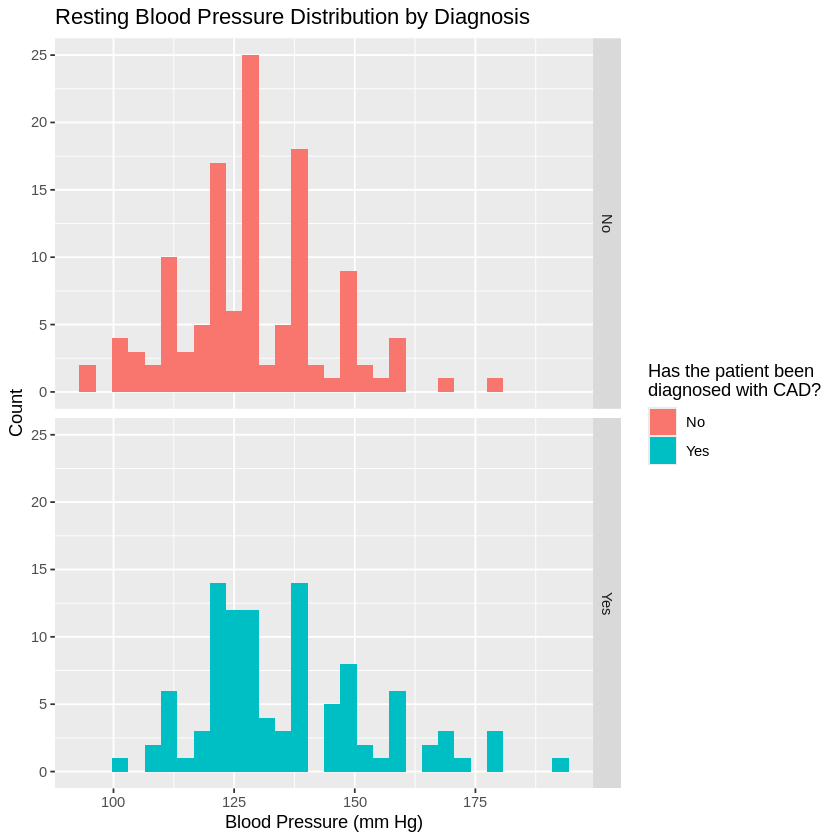

In [53]:
set.seed(111)

# Generating a histogram illustrating the distribution of resting blood pressure levels among patients, categorized by diagnosis
bp_hist_plot <- heart_data_training |>
    ggplot(aes(x = trestbps, fill = diagnosis)) +
    geom_histogram(position = "identity") +
    ggtitle("Resting Blood Pressure Distribution by Diagnosis") +
    labs(x = "Blood Pressure (mm Hg)", y = "Count", fill = "Has the patient been \ndiagnosed with CAD?") +
    facet_grid(rows = vars(diagnosis))
bp_hist_plot

The plot above suggests that although the density between 125 and 150 mm Hg remains similar, individuals diagnosed with the condition demonstrate higher variability in their blood pressure levels.

#### **Methods**
According to Reule & Drawz (2012) and CDC (2024), the best predictors of coronary artery disease are age, cholesterol level, sex, blood pressure, and heart rate. However, from my preliminary analysis, I found that age, resting blood pressure, and maximum heart rate are the strongest predictors of CAD. Therefore, I will focus on these three variables for my project. 

Before proceeding, I will split the dataset into training and testing sets, with the training set comprising 75% and the testing set 25% of the data. The process of building my classification model will involve standardizing the data for my variables to ensure comparability. Then, I will tune my K-Nearest Neighbor classifier through cross-validation to ascertain the optimal K value. Subsequently, I will assess the model's performance using the testing dataset, ensuring optimal accuracy by analyzing our metrics and the confusion matrix.

To visualize the relationships among the three variables, I will utilize scatter plots and histograms. Scatterplots will help identify any cross-correlational relationships, while histograms will provide insights into the distribution of individual variables.

#### **Expected outcomes and significance:**
From my analysis, I expect to find relationships between age, maximum heart rate, resting blood pressure, and the risks of coronary artery disease. The impact of my analysis may lead to a more efficient and accurate system to detect heart diseases by using the data of patients. This is important because it can detect early onset of heart diseases, which allows for a higher chance of treating it and a higher range of treatments.

This exploration could lead to questions about discovering new biological factors or lifestyle factors that might enhance CAD prediction models. Additionally, it may spark investigations into whether similar modeling approaches can be applied to other heart conditions, potentially expanding our ability to predict and manage various cardiovascular diseases.

#### **References**

CDC. (2024, May 20). About coronary artery disease (CAD). Heart Disease. https://www.cdc.gov/heart-disease/about/coronary-artery-disease.html

Coronary artery disease. (2022, May 25). Mayo Clinic. https://www.mayoclinic.org/diseases-conditions/coronary-artery-disease/symptoms-causes/syc-20350613

Reule, S., & Drawz, P. E. (2012). Heart rate and blood pressure: Any possible implications for management of hypertension? Current Hypertension Reports, 14(6), 478–484. https://doi.org/10.1007/s11906-012-0306-3